In [1]:
import sys
import sklearn
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

Прочитам тренировъчните данни и ги копирам в data.

In [2]:
original = pd.read_csv('data/spooky/train.csv', index_col=[0])
data = original.copy()

data.shape

(19579, 2)

In [3]:
data.head(10)

,text,author
id,,
id26305,"This process, however, afforded me no means of...",EAP
id17569,It never once occurred to me that the fumbling...,HPL
id11008,"In his left hand was a gold snuff box, from wh...",EAP
id27763,How lovely is spring As we looked from Windsor...,MWS
id12958,"Finding nothing else, not even gold, the Super...",HPL
id22965,"A youth passed in solitude, my best years spen...",MWS
id09674,"The astronomer, perhaps, at this point, took r...",EAP
id13515,The surcingle hung in ribands from my body.,EAP
id19322,I knew that you could not say to yourself 'ste...,EAP


Ще визуализирам дяловете на цитатите на тримата автори в тренировъчните данни

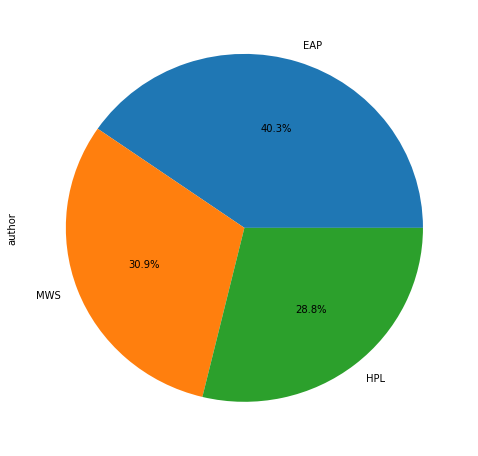

In [4]:
data['author'].value_counts().plot.pie(figsize=(8, 8), autopct='%1.1f%%');

Най-много са цитатите на Едгар Алън По, но разликата в големината на дяловете не е много голяма.

Най-често срещаните думи както се очаква са stopwords.

In [5]:
all_words = data['text'].str.split(expand=True).unstack().value_counts()
all_words.head(10)

the     33296
of      20851
and     17059
to      12615
I       10382
a       10359
in       8787
was      6440
that     5988
my       5037
dtype: int64

За начален модел ще пробвам с CountVectorizer и различни класификатори.

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(data.text)
X_train_counts.shape

(19579, 25068)

От CountVectorizer получавам 25068 features.

Първо пробвам с LinearSVC.

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

pipeline = Pipeline([
    ('features', CountVectorizer()),
    ('clf', LinearSVC())
])

print(cross_val_score(pipeline, data.text, data.author, cv=3, n_jobs=3))

[ 0.78783701  0.79635305  0.79509579]


Сравнително добър резултат като за начало. Сега ще пробвам с RandomForest. Ще изведа и negative log loss score, защото така се оценява в съзтезанието в kaggle.

In [8]:
from sklearn.ensemble import RandomForestClassifier
pipeline = Pipeline([
    ('features', CountVectorizer()),
    ('clf', RandomForestClassifier())
])

print(cross_val_score(pipeline, data.text, data.author, cv=3, n_jobs=3))
print(cross_val_score(pipeline, data.text, data.author, cv=3, n_jobs=3, scoring='neg_log_loss'))

[ 0.60401348  0.61722341  0.61685824]
[-1.4360023  -1.42338502 -1.36410404]


С RandomForest получавам по-лоши резултати. Ще пробвам с логистична регресия и с MultinomiaNB.

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

pipeline1 = Pipeline([
    ('features', CountVectorizer()),
    ('clf', LogisticRegression())
])

print("LogisticRegression: ")
print(cross_val_score(pipeline1, data.text, data.author, cv=3, n_jobs=3))
print(cross_val_score(pipeline1, data.text, data.author, cv=3, n_jobs=3, scoring='neg_log_loss'))


pipeline2 = Pipeline([('vect', CountVectorizer()),
                    ('clf', MultinomialNB()),
                   ])

print("MultinomiaNB: ")
print(cross_val_score(pipeline2, data.text, data.author, cv=3, n_jobs=3))
print(cross_val_score(pipeline2, data.text, data.author, cv=3, n_jobs=3, scoring='neg_log_loss'))

LogisticRegression: 
[ 0.81449142  0.8168863   0.81348659]
[-0.47678373 -0.47558868 -0.47131484]
MultinomiaNB: 
[ 0.83455882  0.83619369  0.83417625]
[-0.48631897 -0.4762863  -0.479489  ]


С MultinomiaNB получавам най-добри резултати. С логистичната регресия negative log loss скора е малко по-добър.

Сега ще пробвам да добавя нови фичъри, свързани с някакви характеристики на текстовете. Броят уникални думи и думи само от главни букви ще ги разделя на общия брой думи в цитата, за да взема отношението и да не се влияе от дължината на цитата.

In [10]:
data = original.copy()
data['words'] = data.text.apply(lambda s: len(str(s).split()))
data['symbols'] = data.text.apply(lambda s: len(str(s)))
data['unique_words'] = data.text.apply(lambda s: len(set(str(s).split())))/data.words
data['only_capital_letter_words'] = data.text.apply(lambda s: sum([str.isupper(w) for w in str(s).split()]))/data.words
data['average_word_length'] = data.text.apply(lambda s: np.mean([len(w) for w in str(s).split()]))

data.head(10)

,text,author,words,symbols,unique_words,only_capital_letter_words,average_word_length
id,,,,,,,
id26305,"This process, however, afforded me no means of...",EAP,41,231,0.853659,0.048780,4.658537
id17569,It never once occurred to me that the fumbling...,HPL,14,71,1.000000,0.000000,4.142857
id11008,"In his left hand was a gold snuff box, from wh...",EAP,36,200,0.888889,0.000000,4.583333
id27763,How lovely is spring As we looked from Windsor...,MWS,34,206,0.941176,0.000000,5.088235
id12958,"Finding nothing else, not even gold, the Super...",HPL,27,174,0.925926,0.000000,5.481481
id22965,"A youth passed in solitude, my best years spen...",MWS,83,468,0.795181,0.060241,4.650602
id09674,"The astronomer, perhaps, at this point, took r...",EAP,21,128,1.000000,0.000000,5.142857
id13515,The surcingle hung in ribands from my body.,EAP,8,43,1.000000,0.000000,4.500000
id19322,I knew that you could not say to yourself 'ste...,EAP,88,488,0.704545,0.045455,4.556818


Ще визуализирам данните относно средните стойности на тези нови фичъри за всеки от авторите.

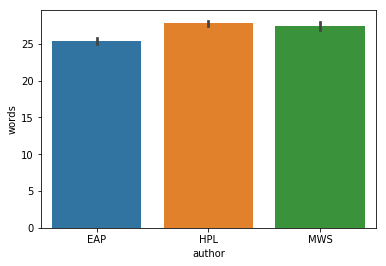

In [11]:
sns.barplot(x="author", y="words", data=data)

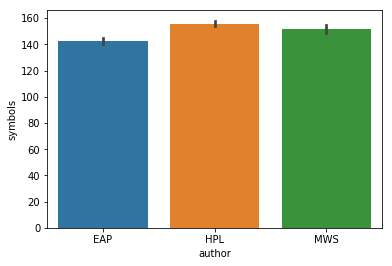

In [12]:
sns.barplot(x="author", y="symbols", data=data);

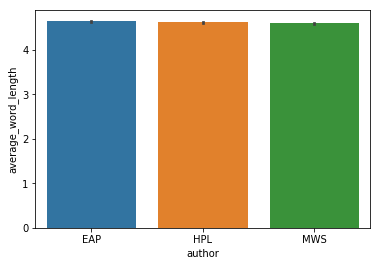

In [13]:
sns.barplot(x="author", y="average_word_length", data=data);

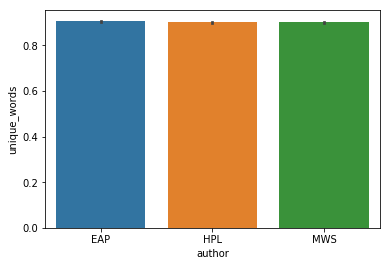

In [14]:
sns.barplot(x="author", y="unique_words", data=data);

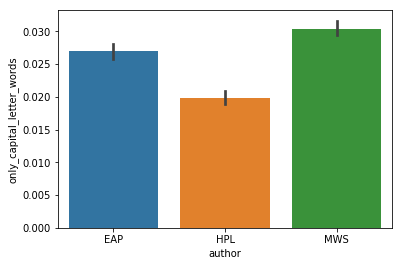

In [15]:
sns.barplot(x="author", y="only_capital_letter_words", data=data);

Това, което забелязвам е , че по-ясно разграничение се забелязва единствено в използваните думи само с главни букви.
Ако тренирам модел само с тези фичъри няма да получа много добри резултати.

In [16]:
from sklearn.ensemble import RandomForestClassifier
features = list(set(data.columns) - {'text', 'author'})
cross_val_score(LinearSVC(), data[features], data.author, cv=3, n_jobs=3)

array([ 0.40349265,  0.40346307,  0.388659  ])

Сега ще добавя тези фичъри към получените от CountVectorizer, за да подобря резултата.

In [17]:
from pandas import DataFrame

cv = CountVectorizer()#binary=True,min_df=0.0001,max_df=5000/19579)
X = cv.fit_transform(data.text)


За да ги конкатенирам, първо ще преобразувам фичърите в дата фрейма в спарс матрица.

In [18]:
import scipy
df = data.drop(['text','author'], axis=1)
X2 = scipy.sparse.csr_matrix(df.values)
X2.shape

(19579, 5)

In [19]:
from scipy.sparse import hstack

X = hstack((X, X2))
X.shape

(19579, 25073)

Отново ще пробвам с различни класификатори.

In [20]:
svc = LinearSVC()
print("LinearSVC: ")
print(cross_val_score(svc, X, data.author, cv=3, n_jobs=3))

lr = LogisticRegression()
print("LogisticRegression: ")
print(cross_val_score(lr, X, data.author, cv=3, n_jobs=3))
print(cross_val_score(lr, X, data.author, cv=3, n_jobs=3, scoring='neg_log_loss'))

mn = MultinomialNB()
print("MultinomiaNB: ")
print(cross_val_score(mn, X, data.author, cv=3, n_jobs=3))
print(cross_val_score(mn, X, data.author, cv=3, n_jobs=3, scoring='neg_log_loss'))

LinearSVC: 
[ 0.67447917  0.72157524  0.77241379]
LogisticRegression: 
[ 0.81755515  0.81703953  0.81869732]
[-0.47069292 -0.46998808 -0.46572929]
MultinomiaNB: 
[ 0.83670343  0.83573399  0.83770115]
[-0.48364976 -0.4726204  -0.47812213]


Няма особено подобрение в резултатите.
Сега ще пробвам да извлека информация относно пунлтуацията. тя може да носи информация относно дължината на изреченията и това до колко сложни са те.

In [21]:

data['?'] = data.text.apply(lambda s: sum([('?' in w) for w in str(s).split()]))
data['!'] = data.text.apply(lambda s: sum([('!' in w) for w in str(s).split()]))
data['.'] = data.text.apply(lambda s: sum([('.' in w) for w in str(s).split()]))
data['"'] = data.text.apply(lambda s: sum([(',' in w) for w in str(s).split()]))
data["'"] = data.text.apply(lambda s: sum([(',' in w) for w in str(s).split()]))
data[','] = data.text.apply(lambda s: sum([(',' in w) for w in str(s).split()]))
data[';'] = data.text.apply(lambda s: sum([(',' in w) for w in str(s).split()]))
data[':'] = data.text.apply(lambda s: sum([(',' in w) for w in str(s).split()]))
data['punctuation'] = data['?']+data['!']+data['.']+data['"']+data["'"]+data[',']+data[';']+data[':']

data.describe()


,words,symbols,unique_words,only_capital_letter_words,average_word_length,?,!,.,"""",',",",;,:,punctuation
count,19579.000000,19579.000000,19579.000000,19579.000000,19579.000000,19579.000000,19579.0,19579.000000,19579.000000,19579.000000,19579.000000,19579.000000,19579.000000,19579.000000
mean,26.730477,149.057408,0.903000,0.025966,4.624827,0.056080,0.0,1.012820,1.951887,1.951887,1.951887,1.951887,1.951887,10.828336
std,19.048353,106.800189,0.081717,0.045063,0.589194,0.248648,0.0,0.429156,2.092199,2.092199,2.092199,2.092199,2.092199,10.518313
min,2.000000,21.000000,0.446128,0.000000,2.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,15.000000,81.000000,0.846154,0.000000,4.250000,0.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000
50%,23.000000,128.000000,0.909091,0.000000,4.590909,0.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000
75%,34.000000,191.000000,1.000000,0.043478,4.952381,0.000000,0.0,1.000000,3.000000,3.000000,3.000000,3.000000,3.000000,16.000000
max,861.000000,4663.000000,1.000000,1.000000,11.000000,4.000000,0.0,16.000000,48.000000,48.000000,48.000000,48.000000,48.000000,241.000000


Колоната '!' е излишна тъй като максималния брой срещания на ! е 0.

In [22]:
data = data.drop('!', axis=1)

Ще визуализирам данните.

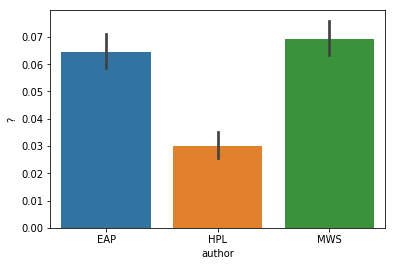

In [23]:
sns.barplot(x="author", y="?", data=data)

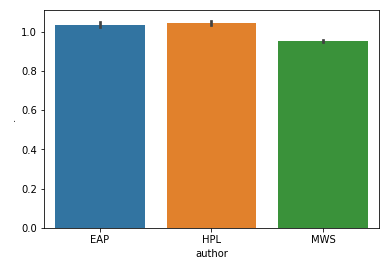

In [24]:
sns.barplot(x="author", y=".", data=data)

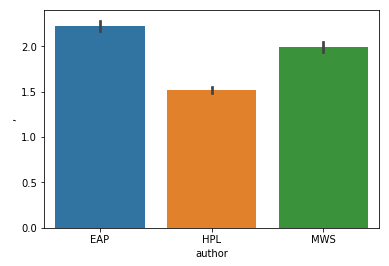

In [25]:
sns.barplot(x="author", y=",", data=data)

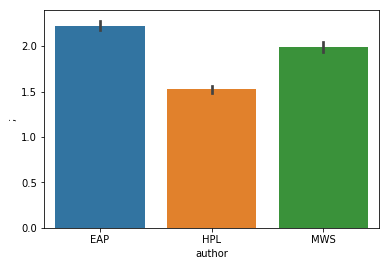

In [26]:
sns.barplot(x="author", y=";", data=data)

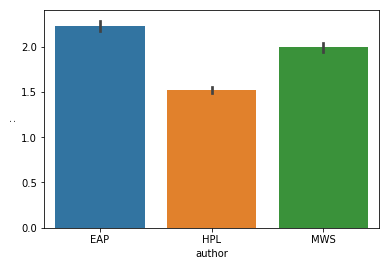

In [27]:
sns.barplot(x="author", y=":", data=data)

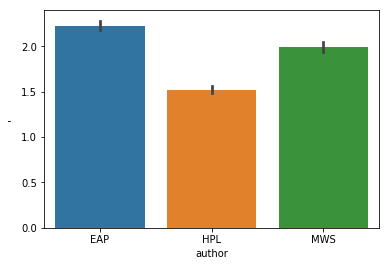

In [28]:
sns.barplot(x="author", y="'", data=data)

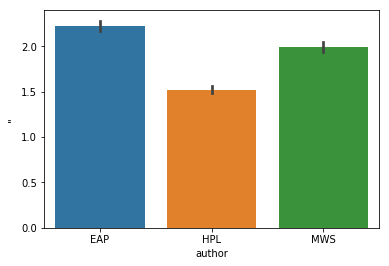

In [29]:
sns.barplot(x="author", y='"', data=data)

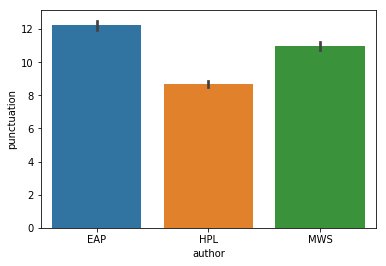

In [30]:
sns.barplot(x="author", y="punctuation", data=data)

Виждам, че пунктуацията носи известна инфорация за автора и затова ще пробвам да я включа в модела.

In [31]:
cv = CountVectorizer(binary=True,min_df=0.0001,max_df=5000/19579)
X = cv.fit_transform(data.text)


df = data.drop(['text','author'], axis=1)
X2 = scipy.sparse.csr_matrix(df.values)
X = hstack((X, X2))

mn = MultinomialNB()
#mn.fit(X,data.author)

print(cross_val_score(mn, X, data.author, cv=3, n_jobs=3))
print(cross_val_score(mn, X, data.author, cv=3, n_jobs=3, scoring='neg_log_loss'))

data.head(10)

[ 0.8002451   0.79528042  0.80275862]
[-0.63908468 -0.65178285 -0.62485951]


,text,author,words,symbols,unique_words,only_capital_letter_words,average_word_length,?,.,"""",',",",;,:,punctuation
id,,,,,,,,,,,,,,,
id26305,"This process, however, afforded me no means of...",EAP,41,231,0.853659,0.048780,4.658537,0,1,4,4,4,4,4,21
id17569,It never once occurred to me that the fumbling...,HPL,14,71,1.000000,0.000000,4.142857,0,1,0,0,0,0,0,1
id11008,"In his left hand was a gold snuff box, from wh...",EAP,36,200,0.888889,0.000000,4.583333,0,1,4,4,4,4,4,21
id27763,How lovely is spring As we looked from Windsor...,MWS,34,206,0.941176,0.000000,5.088235,0,1,3,3,3,3,3,16
id12958,"Finding nothing else, not even gold, the Super...",HPL,27,174,0.925926,0.000000,5.481481,0,1,2,2,2,2,2,11
id22965,"A youth passed in solitude, my best years spen...",MWS,83,468,0.795181,0.060241,4.650602,0,1,4,4,4,4,4,21
id09674,"The astronomer, perhaps, at this point, took r...",EAP,21,128,1.000000,0.000000,5.142857,0,1,3,3,3,3,3,16
id13515,The surcingle hung in ribands from my body.,EAP,8,43,1.000000,0.000000,4.500000,0,1,0,0,0,0,0,1
id19322,I knew that you could not say to yourself 'ste...,EAP,88,488,0.704545,0.045455,4.556818,0,1,7,7,7,7,7,36


Резултата стана по-лош. Ще махна част от пункт. знаци и общия им брой, който може би колерира с другите колони.
След като съм извлякла информация от пунктуацията ще я премахна от текста.

In [32]:
data = data.drop(['"',"'",';',':','punctuation'], axis=1)

def replace(text, punct):
        for p in punct:
            text = text.replace(p,' ')
        return text
    
punct = [',','?','.','"',"'",';',':','!']

data['text'] = data.text.apply(lambda s: replace(str(s), punct))

data.head()

,text,author,words,symbols,unique_words,only_capital_letter_words,average_word_length,?,.,","
id,,,,,,,,,,
id26305,This process however afforded me no means of...,EAP,41,231,0.853659,0.04878,4.658537,0,1,4
id17569,It never once occurred to me that the fumbling...,HPL,14,71,1.000000,0.00000,4.142857,0,1,0
id11008,In his left hand was a gold snuff box from wh...,EAP,36,200,0.888889,0.00000,4.583333,0,1,4
id27763,How lovely is spring As we looked from Windsor...,MWS,34,206,0.941176,0.00000,5.088235,0,1,3
id12958,Finding nothing else not even gold the Super...,HPL,27,174,0.925926,0.00000,5.481481,0,1,2


Ще пробвам да добавя още няколко фичъра, които може да са по-характерни за някой от авторите:
    -брой на негативните думи/представки в текста
    -дали текста е разказан от първо лице
    -брой на използваните имена в текста

In [33]:
data['negative'] = data.text.apply(lambda s: sum(
    [('not' in w or 'dis' in w or 'ir' in w or 'il' in w or 'im' in w) for w in str(s).split()]))
data['I'] = (data.text.apply(lambda s: True in[('I' in w or 'me' in w or 'my' in w or 'we' in w) for w in str(s).split()])).astype(float)
data['names'] = data.text.apply(lambda s: sum([str.isupper(w[0]) for w in str(s).split()]))

data.head(10)


,text,author,words,symbols,unique_words,only_capital_letter_words,average_word_length,?,.,",",negative,I,names
id,,,,,,,,,,,,,
id26305,This process however afforded me no means of...,EAP,41,231,0.853659,0.048780,4.658537,0,1,4,2,1.0,3
id17569,It never once occurred to me that the fumbling...,HPL,14,71,1.000000,0.000000,4.142857,0,1,0,0,1.0,1
id11008,In his left hand was a gold snuff box from wh...,EAP,36,200,0.888889,0.000000,4.583333,0,1,4,2,1.0,1
id27763,How lovely is spring As we looked from Windsor...,MWS,34,206,0.941176,0.000000,5.088235,0,1,3,2,1.0,4
id12958,Finding nothing else not even gold the Super...,HPL,27,174,0.925926,0.000000,5.481481,0,1,2,2,0.0,2
id22965,A youth passed in solitude my best years spen...,MWS,83,468,0.795181,0.060241,4.650602,0,1,4,4,1.0,5
id09674,The astronomer perhaps at this point took r...,EAP,21,128,1.000000,0.000000,5.142857,0,1,3,0,1.0,1
id13515,The surcingle hung in ribands from my body,EAP,8,43,1.000000,0.000000,4.500000,0,1,0,0,1.0,1
id19322,I knew that you could not say to yourself ste...,EAP,88,488,0.704545,0.045455,4.556818,0,1,7,6,1.0,7


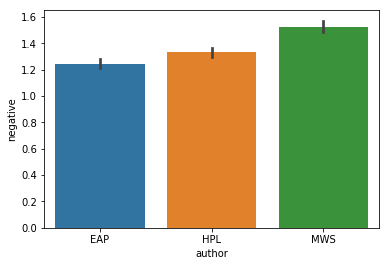

In [34]:
sns.barplot(x="author", y="negative", data=data)

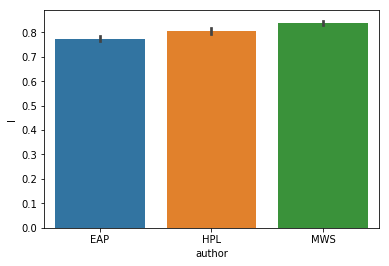

In [35]:
sns.barplot(x="author", y="I", data=data)


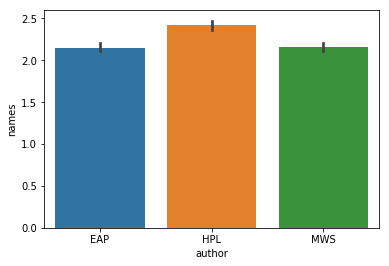

In [36]:
sns.barplot(x="author", y="names", data=data)

Има малка разлика в използваните от авторите негативни думи, имена и текстове от първо лице. Това може да се окаже полезно.
Ще пробвам да тренирам модел с тези данни.

In [37]:
X = cv.fit_transform(data.text)

df = data.drop(['text','author'], axis=1)
X2 = scipy.sparse.csr_matrix(df.values)
X = hstack((X, X2))

mn = MultinomialNB()
print(cross_val_score(mn, X, data.author, cv=3, n_jobs=3))
print(cross_val_score(mn, X, data.author, cv=3, n_jobs=3, scoring='neg_log_loss'))

lr= LogisticRegression()


print(cross_val_score(lr, X, data.author, cv=3, n_jobs=3))
print(cross_val_score(lr, X, data.author, cv=3, n_jobs=3, scoring='neg_log_loss'))

[ 0.84604779  0.84661355  0.84229885]
[-0.44274938 -0.43195773 -0.44041342]
[ 0.81724877  0.82133006  0.82068966]
[-0.46250443 -0.46393137 -0.45712546]


След тестване на ръка успях да подбера хиперпараметри за CountVectorizer, които дават по-добър score.

In [38]:
cv = CountVectorizer(lowercase=False, binary=True, min_df=0.0001,max_df=5000/19579)
X = cv.fit_transform(data.text)

df = data.drop(['text','author'], axis=1)
X2 = scipy.sparse.csr_matrix(df.values)
X = hstack((X, X2))

mn = MultinomialNB()
print(cross_val_score(mn, X, data.author, cv=3, n_jobs=3))
print(cross_val_score(mn, X, data.author, cv=3, n_jobs=3, scoring='neg_log_loss'))

[ 0.8471201   0.85182348  0.84750958]
[-0.43142161 -0.4204744  -0.42819903]


Ще пробвам да задам хиперпараметър алфа на CountVectorizer. Ще го подбера с помощта на GridSearch.

In [39]:
from sklearn.model_selection import GridSearchCV

gs = GridSearchCV(mn,{'alpha':[0.01,0.03,0.08,0.1,0.5,0.6,0.7,0.8,0.9,1]})
gs.fit(X, data.author)
pd.DataFrame(gs.cv_results_)[['rank_test_score', 'mean_test_score', 'params']].sort_values(by='rank_test_score').head(10)

,rank_test_score,mean_test_score,params
4,1,0.851065,{'alpha': 0.5}
5,2,0.849992,{'alpha': 0.6}
6,3,0.849686,{'alpha': 0.7}
8,4,0.849533,{'alpha': 0.9}
7,5,0.849073,{'alpha': 0.8}
9,6,0.848818,{'alpha': 1}
3,7,0.848154,{'alpha': 0.1}
2,8,0.846826,{'alpha': 0.08}
1,9,0.842076,{'alpha': 0.03}
0,10,0.837479,{'alpha': 0.01}


Най-добър резултат има при алфа=0.6. Пробвам с алфа=0.6 и cross validation.

In [40]:
mn = MultinomialNB(alpha=0.5)

print(cross_val_score(mn, X, data.author, cv=3, n_jobs=3))
print(cross_val_score(mn, X, data.author, cv=3, n_jobs=3, scoring='neg_log_loss'))

[ 0.85186887  0.85090408  0.85042146]
[-0.44073235 -0.42916394 -0.43938534]


Сега ще пробвам да сменя CountVectorizer с TfidfVectorizer.

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf = TfidfVectorizer()
X = tf.fit_transform(data.text)
X = hstack((X, X2))

mn = MultinomialNB()

print(cross_val_score(mn, X, data.author, cv=3, n_jobs=3))
print(cross_val_score(mn, X, data.author, cv=3, n_jobs=3, scoring='neg_log_loss'))

[ 0.68106618  0.67008888  0.68291188]
[-0.68791486 -0.70505002 -0.69074672]


Полъчавам доста по-лош score. Ще пробвам да променя хиперпараметрите.

In [42]:

tf = TfidfVectorizer(lowercase=False,binary=True,ngram_range=(1,2))
X = tf.fit_transform(data.text)
X = hstack((X, X2))

mn = MultinomialNB()

print(cross_val_score(mn, X, data.author, cv=3, n_jobs=3))
print(cross_val_score(mn, X, data.author, cv=3, n_jobs=3, scoring='neg_log_loss'))

[ 0.40349265  0.40346307  0.4035249 ]
[-5.20173457 -5.46573832 -5.31198545]


Много лош резултат. Все пак ще пробвам с GridSearch MultinomialNB.

In [43]:
gs = GridSearchCV(mn,{'alpha':[0.01,0.03,0.08,0.1,0.5,0.6,0.7,0.8,0.9,1]})
gs.fit(X, data.author)
pd.DataFrame(gs.cv_results_)[['rank_test_score', 'mean_test_score', 'params']].sort_values(by='rank_test_score').head(10)

,rank_test_score,mean_test_score,params
1,1,0.851065,{'alpha': 0.03}
0,2,0.846417,{'alpha': 0.01}
2,3,0.841463,{'alpha': 0.08}
3,4,0.823689,{'alpha': 0.1}
4,5,0.407426,{'alpha': 0.5}
5,6,0.404668,{'alpha': 0.6}
6,7,0.403953,{'alpha': 0.7}
7,8,0.403647,{'alpha': 0.8}
8,9,0.403545,{'alpha': 0.9}
9,10,0.403494,{'alpha': 1}


Не знам защо, но за алфа<=0.1 получавам доста по-добър резултат.

In [44]:
mn = MultinomialNB(alpha=0.03)

print(cross_val_score(mn, X, data.author, cv=3, n_jobs=3))
print(cross_val_score(mn, X, data.author, cv=3, n_jobs=3, scoring='neg_log_loss'))

[ 0.85585172  0.85182348  0.84551724]
[-0.39377993 -0.39472486 -0.39713826]


Доста по-добър резултат за negative log loss. Ще събера всичко в два трансформатора, ще ги сложа в pipeline и ще пробвам в kaggle.
В първия трансформатор ще сложа добавянето на фичърите, а във втория ще сложа векторизирането на текста с подаден векторизатор и конкатенацията на двете.

In [45]:
from sklearn.base import TransformerMixin



class Tr1(TransformerMixin):
    def replace(self, text, punct):
        for p in punct:
            text = text.replace(p,' ')
        return text
    
    def transform(self, data2):
        data = data2.copy()
        data['words'] = data.text.apply(lambda s: len(str(s).split()))
        data['unique_words'] = data.text.apply(lambda s: len(set(str(s).split())))/data['words']
        data['only_capital_letter_words'] = (data.text.apply(lambda s: True in [str.isupper(w) for w in str(s)])).astype(float)
        data['average_word_length'] = data.text.apply(lambda s: np.mean([len(w) for w in str(s).split()]))
        
        data['?'] = data.text.apply(lambda s: sum([('?' in w) for w in str(s).split()]))
        data['.'] = data.text.apply(lambda s: sum([('.' in w) for w in str(s).split()]))
        data[','] = data.text.apply(lambda s: sum([(',' in w) for w in str(s).split()]))
        punct = ['.',',','?','!',';',':','-','"',"'"]
        
        data['negative'] =data.text.apply(lambda s: sum(
            [('not' in w or 'dis' in w or 'ir' in w or 'il' in w or 'im' in w) for w in str(s).split()]))
        data['I'] = (data.text.apply(lambda s: True in[('I' in w or 'me' in w or 'my' in w) for w in str(s).split()])).astype(float)
        data['names'] = data.text.apply(lambda s: sum([str.isupper(w[0]) for w in str(s).split()]))
        
        data['text']=data.text.apply(lambda s: self.replace(str(s), punct))
        
        data['symbols'] = data.text.apply(lambda s: len(str(s)))
        return data
    
    def fit(self, data, y):
        return self
    

    
class Tr2(TransformerMixin):
    def __init__(self, vect):
        self.vect = vect
        
    def fit(self, data, y):
        self.vect.fit(data.text)
        return self
        
    def transform(self, data):
        X = self.vect.transform(data.text)
        df = data.drop(['text'], axis=1)
        X2 = scipy.sparse.csr_matrix(df.values)
        X = hstack((X, X2))
        return X
    
        
    




In [46]:
from sklearn.model_selection import train_test_split

cv=TfidfVectorizer(lowercase=False, binary=True, ngram_range=(1,2))
pipeline = Pipeline([
('tr1', Tr1()),
('tr2', Tr2(cv)),
('mnb', MultinomialNB(alpha=0.03)),
])


train = pd.read_csv('data/spooky/train.csv', index_col=[0])
test = pd.read_csv('data/spooky/test.csv', index_col=[0])

X = train.drop('author', 1)
y = train['author']

print(cross_val_score(pipeline, X, y, cv=3, n_jobs=1))
print(cross_val_score(pipeline, X, y, cv=3, n_jobs=1, scoring='neg_log_loss'))


[ 0.8549326   0.85151701  0.8456705 ]
[-0.37325238 -0.37536459 -0.3799547 ]


Ще тренирам модела с всички тренировъчни данни и ще предиктна за тестовите данни.

In [47]:

pipeline = pipeline.fit(train.drop(['author'],axis=1), train.author)
test_predictions = pipeline.predict_proba(test)
test_predictions

array([[ 0.08118652,  0.00470666,  0.91410683],
       [ 0.94778138,  0.01804529,  0.03417333],
       [ 0.00913485,  0.98614398,  0.00472117],
       ..., 
       [ 0.99358713,  0.00186575,  0.00454712],
       [ 0.01411439,  0.00201332,  0.98387229],
       [ 0.29690387,  0.69181293,  0.01128319]])

In [48]:
submit_file = pd.DataFrame(test_predictions, columns=['EAP', 'HPL', 'MWS'], index=test.index)
submit_file.to_csv("data/spooky/submit.csv")

submit_file.head(10)

,EAP,HPL,MWS
id,,,
id02310,0.081187,0.004707,0.914107
id24541,0.947781,0.018045,0.034173
id00134,0.009135,0.986144,0.004721
id27757,0.770349,0.219350,0.010301
id04081,0.662608,0.234005,0.103387
id27337,0.997060,0.002736,0.000203
id24265,0.974354,0.016607,0.009040
id25917,0.005404,0.038865,0.955730
id04951,0.997881,0.002063,0.000056


Резултат в kaggle :0.33915

За крайния резултат използвах фичърите:
    - 'words', 'unique_words', 'only_capital_letter_words', 'average_word_length', 'symbols';
    - '.', '?', ',' (брой на тези знаци в текст)
    - 'negative' (брой отрицателни думи и представки)
    -  'I' (дали текстът е в първо лице)
    -  'names'(брой имена в текста)
    
Премахнах пунктуацията от текста и го прекарах през TfidfVectorizer(lowercase=False, binary=True, ngram_range=(1,2)).
Обединих всички фичъри и тренирах с тях MultinomialNB(alpha=0.03).